# Finetuning a pretrained NDT3 model
This notebook will illustrate how to finetune and evaluate a pretrained NDT3 model on a new dataset.
Here, we'll use a single session of the O'Doherty RTT dataset. This notebook assumes:
- you have installed the ndt3 codebase.
- you have an bf16-capable (Ampere or later) GPU (for running the model)
- you have setup wandb

In [3]:
# Retrieve a single session (indy_20160407_02.mat)
# https://zenodo.org/records/3854034/files/indy_20160407_02.mat?download=1
import os
import requests

# Create a directory to store the dataset if it doesn't exist
os.makedirs('data/rtt', exist_ok=True)

# URL of the dataset
url = "https://zenodo.org/records/3854034/files/indy_20160407_02.mat?download=1"

# Download the file
print("Downloading the dataset...")
data_path = os.path.join('data/rtt', 'indy_20160407_02.mat')
if not os.path.exists(data_path):
    r = requests.get(url, allow_redirects=True)
    with open(data_path, 'wb') as file:
        file.write(r.content)
# Print completed file path
print(f"Downloaded to {os.path.abspath(data_path)}")


Downloaded to /home/joy47/projects/ndt3/data/rtt/indy_20160407_02.mat


In [4]:
# Download a pretrained model. Here we download a 45M 200h model.
# Use the HuggingFace git LFS strategy
# Create a directory to store the model if it doesn't exist
pt_dir = 'data/pretrained'
if not os.path.exists(pt_dir):
    !git lfs install
    !git clone git@hf.co:joel99/ndt3 data/pretrained

pt_model_path = os.path.join(pt_dir, '753jmg4u/checkpoints/val-epoch=397-val_loss=0.4987.ckpt')

In [5]:
# Initialize NDT3 dataset


# First we declare the location of the downloaded data as a dataset with an associated task definition.
# This task definition allows routing of the data to the correct preprocessing pipeline.
from context_general_bci.utils import suppress_default_registry
suppress_default_registry()
from context_general_bci.contexts.context_info import RTTContextInfo
from context_general_bci.contexts.context_registry import context_registry
context_registry.register([*RTTContextInfo.build_several('./data/rtt', alias_prefix='rtt')])

# Create tuning config
from context_general_bci.config import RootConfig, propagate_config
from hydra import compose, initialize_config_module
try:
    initialize_config_module(
        config_module="context_general_bci.config",
        job_name="demo_rtt",
        version_base="1.3",
    )
except:
    print('Hydra Initialize failed, assuming this is not the first decoder.')

# type: ignore
cfg: RootConfig = compose(config_name="config", overrides=[f"+exp/v5/tune/rtt=smoketest"])
propagate_config(cfg)

cfg.dataset.datasets = ['rtt']
cfg.dataset.eval_datasets = ['rtt']
cfg.dataset.eval_ratio = 0.9 # About 80s of training data (1s per datapoint), 720s of eval
cfg.train.batch_size= 16


In [6]:
import dataclasses
import torch
import copy
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

from omegaconf import OmegaConf
import wandb

from context_general_bci.dataset import SpikingDataset, SpikingDataModule
from context_general_bci.model import BrainBertInterface, load_from_checkpoint

pl.seed_everything(seed=cfg.seed)

cfg.experiment_set = "demo"
cfg.wandb_project = "ndt3" # ! YOUR WANDB PROJECT HERE!
cfg.wandb_user = "pitt-bci" # ! YOUR WANDB USER HERE!

# Feel free to tweak these training parameters
cfg.train.epochs = 100 # Keep training short for demonstration
cfg.model.lr_decay_steps = 100
cfg.train.patience = 100
pt_cfg = copy.deepcopy(cfg)

cfg.tag = "smoketest-scratch"
cfg.model.lr_init = 3e-4

pt_cfg.tag = 'smoketest-pt'
pt_cfg.model.lr_init = 1e-4

dataset = SpikingDataset(cfg.dataset)
dataset.build_context_index()

eval_dataset = copy.deepcopy(dataset)
eval_dataset.subset_split(splits=['eval'], keep_index=True)
dataset.subset_split(keep_index=True)
data_attrs = dataset.get_data_attrs()
train, val = dataset.create_tv_datasets(train_ratio=cfg.dataset.tv_ratio)

# Initialize model
pt_model = load_from_checkpoint(pt_model_path, cfg=cfg.model, data_attrs=data_attrs)
scratch_model = BrainBertInterface(cfg.model, data_attrs)

def train_model(cfg: RootConfig, model: BrainBertInterface):
    # reinitialize several items to prevent stateful behavior
    wandb.init(project=cfg.wandb_project, entity=cfg.wandb_user)
    wandb_logger = WandbLogger(project=cfg.wandb_project, save_dir=cfg.default_root_dir)
    _ = wandb_logger.experiment # force experiment recognition so that id is initialized
    wandb.run.name = f'{cfg.tag}-{wandb.run.id}'
    wandb.config.update(OmegaConf.to_container(cfg, resolve=True))
    wandb.config.update({'data_attrs': dataclasses.asdict(data_attrs)})

    callbacks = [
        ModelCheckpoint(monitor='val_kinematic_r2', save_top_k=cfg.save_num, mode='max', filename='val_kinematic_r2-{epoch:02d}-{val_kinematic_r2:.4f}-{val_loss:.4f}'),
        EarlyStopping(monitor='val_kinematic_r2', patience=cfg.train.patience, mode='max'),
        LearningRateMonitor(logging_interval='step'),
    ]
    data_module = SpikingDataModule(
        cfg.train.batch_size,
        num_workers=8, # Adjust to CPU cores if preferred
        train=train,
        val=[val, eval_dataset]
    )
    # Setup trainer
    trainer = pl.Trainer(
        logger=wandb_logger,
        max_epochs=cfg.train.epochs,
        callbacks=callbacks,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices="auto",
        check_val_every_n_epoch=None if cfg.train.val_check_interval else 1,
        log_every_n_steps=cfg.train.log_every_n_steps,
        val_check_interval=cfg.train.val_check_interval if cfg.train.val_check_interval > 0 else None,
        precision='bf16-mixed' if cfg.model.half_precision else 32,
        strategy="auto",
        gradient_clip_val=cfg.train.gradient_clip_val,
        accumulate_grad_batches=cfg.train.accumulate_batches,
    )
    trainer.fit(model, datamodule=data_module)
    wandb.finish()

# Train the model
train_model(cfg, scratch_model)
train_model(pt_cfg, pt_model)

/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.0, which is newer than your current Lightning version: v2.1.0
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joelye9 (pitt-bci). Use `wandb login --relogin` to force relogin


/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') th

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Sanity Checking DataLoader 1: 100%|██████████| 2/2 [00:00<00:00, 68.60it/s]

/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('token_proc', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.


Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, v_num=4q3j]         

/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  7.40it/s, v_num=4q3j]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s, v_num=4q3j]


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
eval_kinematic_linear_loss,▂▂▃▂▂▂▆▂▂▂▂▂█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_kinematic_r2,███████▆▁▇██████████████████████████████
eval_loss,█▇▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_spike_infill_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kin_maskout,▂▅▁▇▂█▇▆▅▂█▂▅▄▇▃▃▅▄▄▁▄▄▁▁▆▆▇▇▅█▆█▆▆▅▆▁▂▄
lr-AdamW,▂▂▂▂▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁
token_proc,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_kinematic_linear_loss,▁▂▂▁▁▂▂▂█▁▂▂▁▂▁▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
train_kinematic_r2_var,███████▁█████████████▇██████████████████
train_loss,██▅▃▂▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁


/home/joy47/mambaforge/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.p

Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  7.38it/s, v_num=gr3h]        

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  7.36it/s, v_num=gr3h]


epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇██████
eval_kinematic_linear_loss,██▅█▅▂▁▃▃▃▃▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_kinematic_r2,▁▄▄▄▄▃▆▅▇██▆▆▇▅▇██▇█████████████████████
eval_loss,▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇███████
eval_spike_infill_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▃▄▄▅▅▅▆▇▇▇██████████
kin_maskout,▅▂▄▃▃▅▂▄▃█▁▇▇▅▁▁▄▅▆▅▂▇▇▇▁▄▂▅▇▆█▇▄▅▅▄▃█▄▇
lr-AdamW,▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇█▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
token_proc,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
train_kinematic_linear_loss,█▇▆▅▆▅▄▃▃▃▂▃▃▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_kinematic_r2_var,████▁███████████████████████████████████
train_loss,▇█▇▇▇█▄▇▇▆▇▆▆▇▆▄▅▆▆▅▄▅▅▃▄▄▁▄▄▄▄▄▄▄▄▄▄▃▃▄


The training curves for the above runs are viewable at this WandB report: https://api.wandb.ai/links/pitt-bci/ondkahv1



# Evaluation

We now visualize predictions on the evaluation set.

In [33]:
from torch.utils.data import DataLoader
from context_general_bci.config import Output
from context_general_bci.analyze_utils import streaming_eval, stream_to_tensor_dict

def get_predictions(cfg: RootConfig, model: BrainBertInterface, dataset: SpikingDataset):
    model.eval()
    model = model.to("cuda")
    outputs, r2, mse, loss = streaming_eval(
        model,
        dataset,
        stream_buffer_s=1.,
        use_kv_cache=True,
        skip_cache_reset=True,
        autoregress_cue=False,
        limit_eval=50, # Crop for brevity / plot legibility
    )
    print(f"R2: {r2:.3f}")
    return stream_to_tensor_dict(outputs, model)

scratch_predictions = get_predictions(cfg, scratch_model, eval_dataset)
pt_predictions = get_predictions(cfg, pt_model, eval_dataset)


INFO:lightning_fabric.utilities.seed:Seed set to 0
  0%|          | 0/735 [00:00<?, ?it/s]

  7%|▋         | 50/735 [00:13<03:07,  3.65it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Computing R2 on 2500 of torch.Size([2500]) points
R2: 0.368


  7%|▋         | 50/735 [00:13<03:07,  3.64it/s]

Computing R2 on 2500 of torch.Size([2500]) points
R2: 0.508


(0.0, 2500.0)

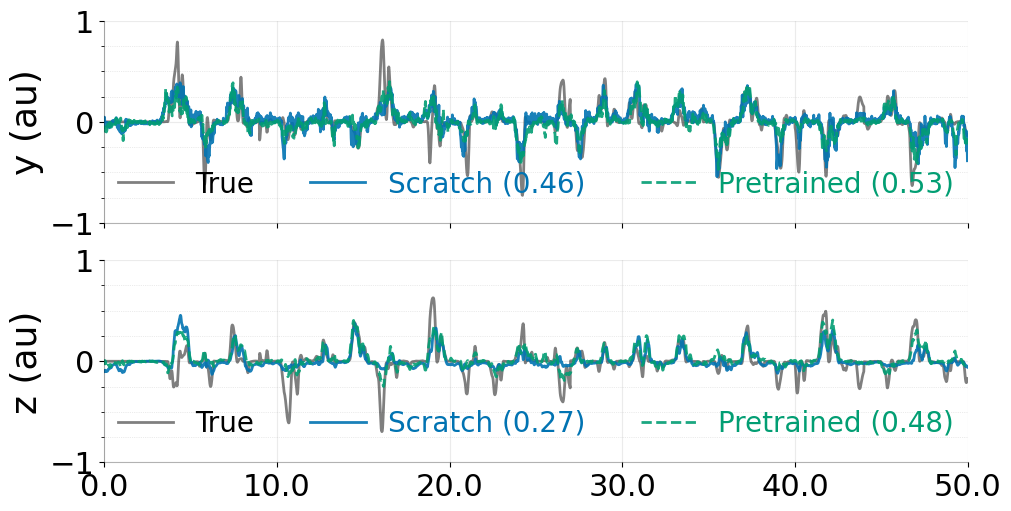

In [34]:
from matplotlib import pyplot as plt
from context_general_bci.config import DataKey
from context_general_bci.plotting import plot_target_pred_overlay_dict, colormap
labels = dataset[0][DataKey.covariate_labels]
subset_dims = range(2)
palette = [colormap['scratch'], colormap['base_45m_200h']]
linestyle = ['-', '--']
scratch_kin_dict = scratch_predictions['kin']
pt_kin_dict = pt_predictions['kin']
merged_predictions = copy.deepcopy(scratch_predictions)
merged_predictions['kin']['model_scratch'] = scratch_kin_dict['behavior_pred']
merged_predictions['kin']['model_pt'] = pt_kin_dict['behavior_pred']
sources = {
    'behavior': 'True',
    'model_scratch': 'Scratch',
    'model_pt': 'Pretrained',
}
fig, axs = plt.subplots(
    len(subset_dims), 1,
    figsize=(10, 5),
    sharex=True,
    sharey=True,
    layout='constrained'
)
kin_dict = merged_predictions['kin']
for i, dim in enumerate(subset_dims):
    merged_predictions['kin'] = kin_dict[:, [dim]]
    axs[i], legend = plot_target_pred_overlay_dict(
        merged_predictions,
        label=labels[i],
        palette=palette,
        linestyle=linestyle,
        sources=sources,
        ax=axs[i],
        plot_trial_markers=False,
    )
axs[0].set_xlim(0, 2500) # Full width